In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnbsl import *

In [5]:
SEASON = '21'
set_seed(int(SEASON))

## Data preparation

In [6]:
path = Path()
path_data = Path('data')

In [7]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [8]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2']
df = df[(df.Div.isin(div)) & (df.Season >= 18) & (df.Season <= 21)]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [9]:
add_datepart(df, 'Date');

In [10]:
procs = [Categorify, FillMissing, Normalize]

In [11]:
valid_idx = list(df.query('Season == 21').index)

In [12]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [13]:
splits

((#12546) [0,1,2,3,4,5,6,7,8,9...],
 (#1415) [918,919,920,921,922,923,924,925,926,927...])

In [14]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam', 'Dayofweek']
# cont_names = list(df.columns[df.columns.str.contains('For') | df.columns.str.contains('Against')]) + ['Year', 'Month', 'Week', 'Day', 'Dayofyear']
cont_names = list(df.columns[df.columns.str.contains('Avg')]) + ['Year', 'Month', 'Week', 'Day', 'Dayofyear']

In [15]:
y_block = RegressionBlock(n_out=2)

In [16]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
9935,I1,Spezia,Juventus,1.0,4.0,11.0,8.0,3.0,5.0,4.0,...,1,6,306,False,True,False,False,False,False,1.604189e+09
12424,SP1,Celta,Granada,1.0,0.0,14.0,7.0,5.0,4.0,5.0,...,27,0,270,False,False,False,False,False,False,1.632701e+09
10046,I1,Udinese,Napoli,1.0,2.0,17.0,15.0,8.0,6.0,2.0,...,10,6,10,False,False,False,False,False,False,1.610237e+09
7291,F1,Dijon,Paris SG,2.0,1.0,10.0,20.0,6.0,4.0,3.0,...,1,4,305,False,True,False,False,False,False,1.572566e+09
11796,SP1,Villarreal,Espanol,1.0,2.0,21.0,16.0,5.0,5.0,4.0,...,19,6,19,False,False,False,False,False,False,1.579392e+09
2649,E0,Burnley,Arsenal,0.0,0.0,15.0,13.0,2.0,2.0,5.0,...,2,6,33,False,False,False,False,False,False,1.580602e+09
6094,E2,Swindon,Burton,4.0,2.0,9.0,8.0,8.0,2.0,5.0,...,26,5,270,False,False,False,False,False,False,1.601078e+09
7700,F1,Angers,Nantes,1.0,3.0,8.0,7.0,3.0,3.0,7.0,...,14,6,45,False,False,False,False,False,False,1.613261e+09
5956,E2,Burton,Accrington,1.0,1.0,10.0,10.0,2.0,3.0,5.0,...,25,5,25,False,False,False,False,False,False,1.579910e+09
12578,SP2,La Coruna,Reus Deportiu,2.0,0.0,16.0,12.0,3.0,3.0,5.0,...,27,5,300,False,False,False,False,False,False,1.540598e+09


In [17]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [18]:
to.cat_names, to.cont_names

((#4) ['Div','HomeTeam','AwayTeam','Dayofweek'],
 (#29) ['FTHGLast5Avg','HSLast5Avg','HSTLast5Avg','HCLast5Avg','FTAGLast5Avg','ASLast5Avg','ASTLast5Avg','ACLast5Avg','HomeFTGForLast5Avg','HomeSForLast5Avg'...])

In [19]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear
13959,11,115,237,4,-0.058513,0.433487,-0.264814,1.011580,0.750485,-0.326777,-0.372938,-1.764759,0.174816,-0.950016,-0.748893,0.088982,0.802293,-0.407229,-0.185079,-1.129227,0.839460,0.334974,-0.034659,-0.256428,-0.509613,-0.628963,-0.774817,-0.352599,1.463393,1.128446,0.983167,-1.321069,1.021625
13960,11,146,223,4,-0.369231,0.933145,0.019284,-0.085169,0.750485,-0.642607,0.425096,-0.705827,-0.824885,-0.043516,-0.900173,0.383812,-0.524710,-0.855514,-1.087846,-0.113866,-0.900022,0.188560,-0.660055,0.038402,0.196965,-0.628963,-0.616663,0.679862,1.463393,1.128446,0.983167,-1.321069,1.021625


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [20]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [21]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [22]:
X_train.shape, y_train.shape

((12546, 33), (12546, 2))

In [23]:
X_test.shape, y_test.shape

((1415, 33), (1415, 2))

## LightGBM

In [24]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [25]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [26]:
import lightgbm as lgbm

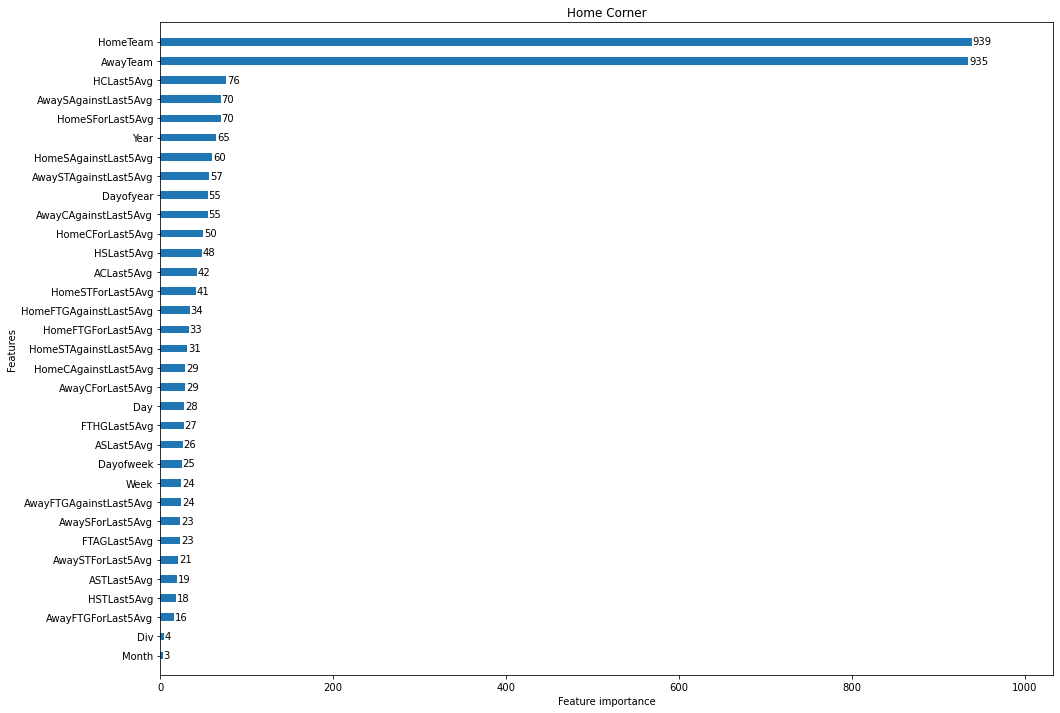

In [27]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

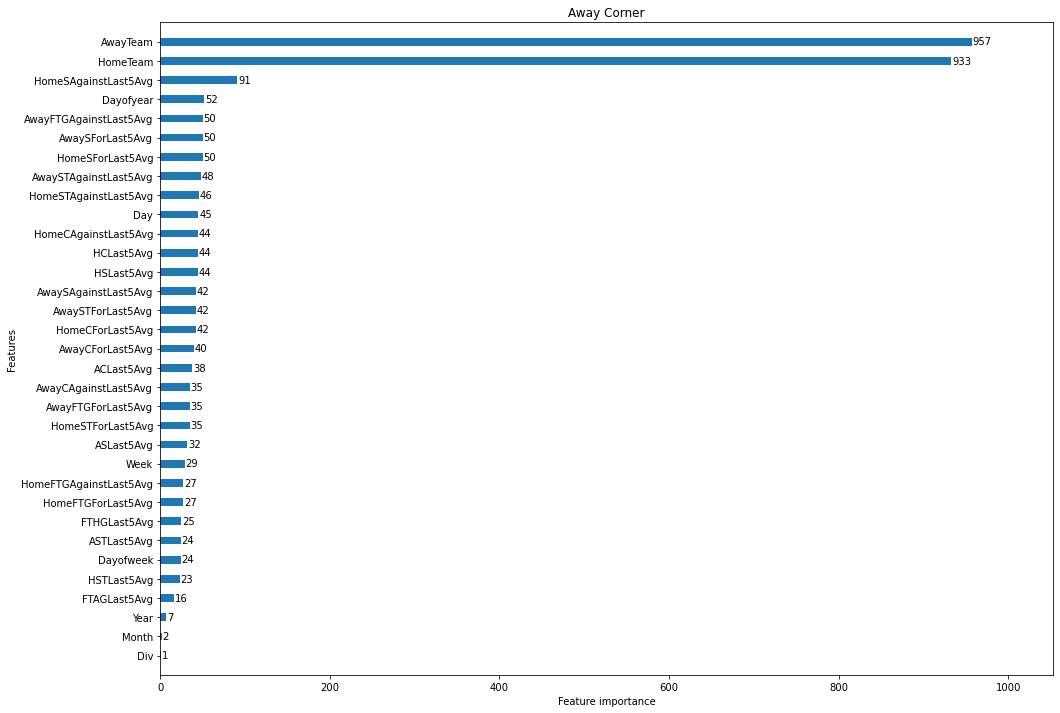

In [28]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [31]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='exact'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [32]:
import xgboost as xgb

In [33]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

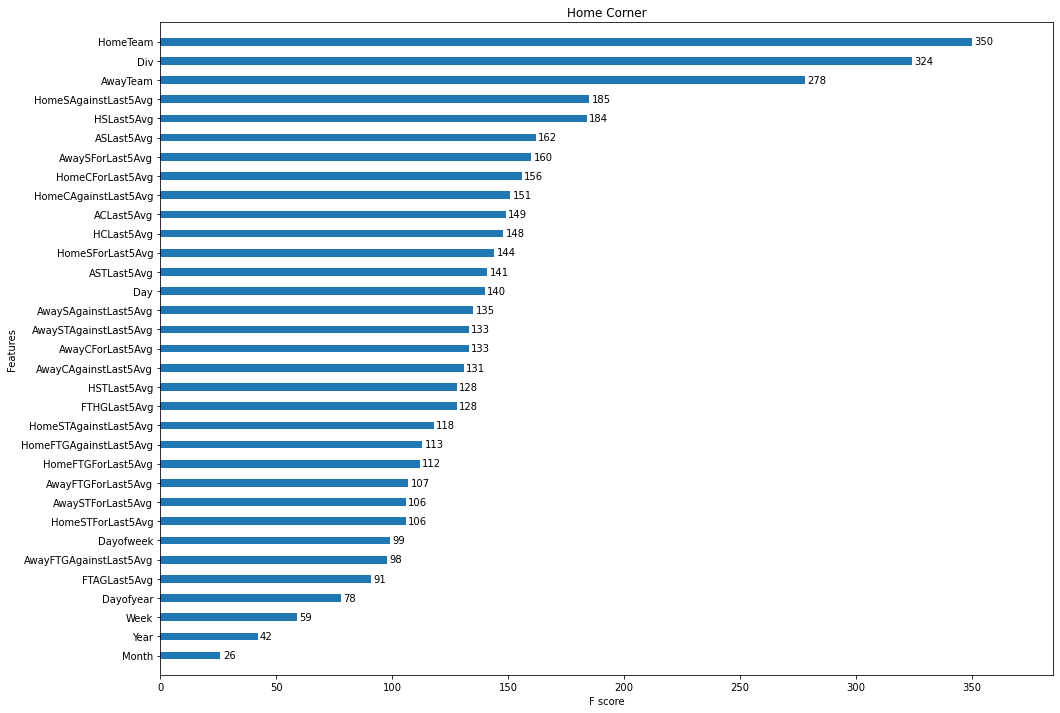

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

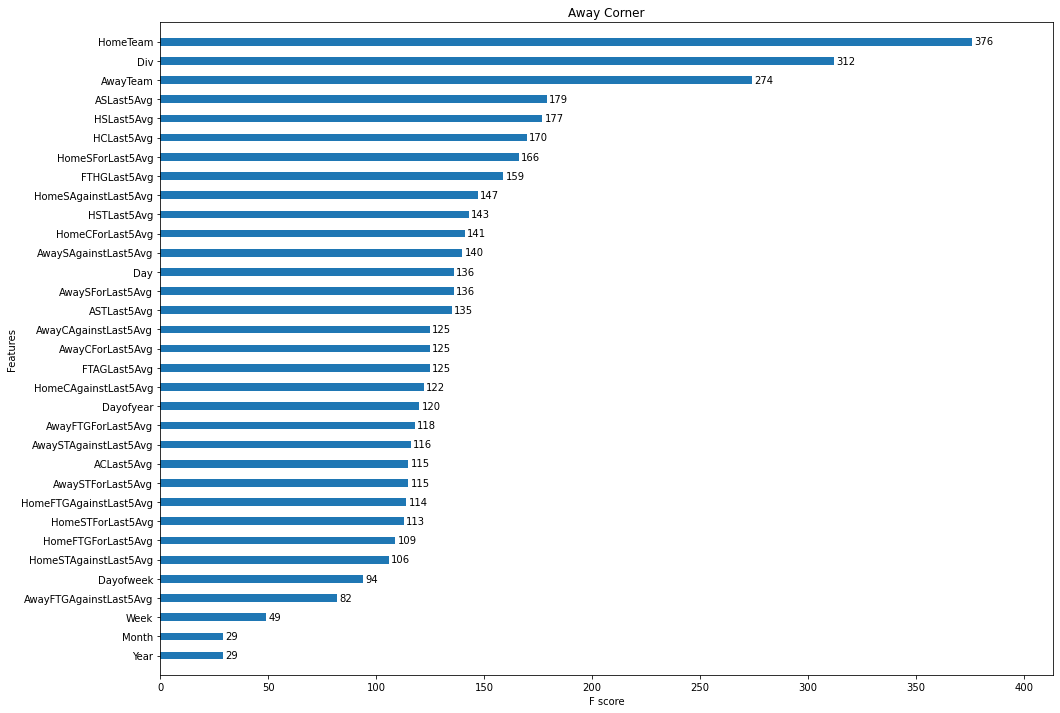

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [36]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC
0,F1,Lyon,Nice,4,2.4,20.400000,8.2,7.0,1.20,12.80,5.0,7.4,1.8,17.400000,6.6,5.6,1.4,16.600000,4.2,7.2,1.2,9.2,2.4,2.8,2.0,12.400000,5.0,5.0,2018.0,8.0,35.000000,31.0,242.999998,10.0,5.0
1,E0,Man City,Fulham,5,3.2,21.799999,8.6,6.6,1.60,14.40,5.2,3.8,2.4,20.799999,7.6,8.8,1.6,14.600000,6.2,3.6,0.6,7.2,2.2,2.2,2.4,14.600000,6.8,4.8,2018.0,9.0,37.000000,15.0,258.000003,10.0,4.0
2,F1,St Etienne,Toulouse,6,1.8,14.800000,5.6,6.0,0.40,9.60,2.2,4.4,0.8,13.400000,4.0,5.2,1.0,12.000000,3.4,4.8,1.4,12.6,5.0,5.8,1.4,15.399999,5.6,5.6,2019.0,9.0,37.000000,15.0,258.000003,9.0,7.0
3,I1,Sampdoria,Parma,5,1.6,11.200000,6.0,5.4,1.20,11.00,4.6,3.4,1.2,12.600000,5.6,5.4,1.2,11.000000,4.0,2.8,1.6,11.4,5.8,5.8,2.8,14.600000,8.2,6.4,2021.0,5.0,20.000000,22.0,142.000001,2.0,4.0
4,F2,Troyes,Brest,4,1.0,10.000000,3.8,5.0,2.00,11.20,5.8,5.0,1.0,9.400000,3.6,4.0,1.8,10.800000,4.8,5.6,1.6,16.4,5.6,5.6,1.0,12.000000,4.4,5.4,2018.0,8.0,31.000000,3.0,215.000001,4.0,9.0
5,SP2,Las Palmas,Sp Gijon,6,1.6,9.000000,3.6,3.8,1.20,11.20,4.6,4.2,1.0,10.000000,3.8,3.4,1.4,11.400000,4.0,4.6,0.4,10.2,2.2,4.4,1.0,11.400000,3.2,5.2,2019.0,2.0,7.000001,17.0,48.000001,6.0,9.0
6,E2,AFC Wimbledon,Crewe,5,1.4,10.800000,4.6,3.4,0.80,11.80,4.4,7.2,1.6,11.200000,5.2,4.6,1.8,15.800000,6.4,7.2,2.6,15.4,5.8,5.8,1.2,8.800000,3.4,2.8,2020.0,12.0,51.000001,19.0,353.999999,3.0,2.0
7,E1,Swansea,Fulham,4,0.6,17.000000,4.8,5.8,1.20,10.40,3.4,5.0,1.2,10.800000,3.8,5.0,1.2,10.600000,3.4,5.6,1.0,13.8,4.4,7.0,0.8,13.400000,3.4,5.0,2019.0,11.0,48.000000,29.0,332.999998,6.0,0.0
8,I2,Brescia,Reggiana,5,2.2,13.400000,5.2,4.8,1.25,10.75,5.5,5.0,1.6,13.000000,4.8,5.6,1.4,8.600001,4.8,3.6,1.6,15.8,6.2,4.6,2.0,18.600000,6.2,5.2,2020.0,12.0,51.000001,19.0,353.999999,0.0,2.0
9,SP2,Sp Gijon,Lugo,0,0.8,9.000000,3.0,4.0,0.60,9.40,3.2,4.2,0.2,10.000000,2.4,5.8,0.6,7.400000,1.8,4.6,0.8,10.4,3.8,3.2,2.0,13.600000,4.8,6.4,2021.0,5.0,19.000000,10.0,129.999999,2.0,0.0


In [37]:
learn = tabular_learner(dls, layers=[240, 120])

In [38]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=114, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [39]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.005248074419796467)

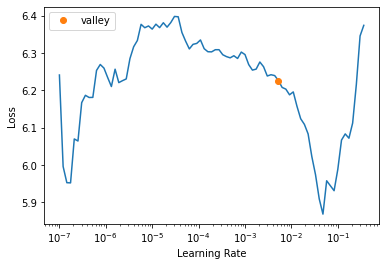

In [40]:
learn.lr_find()

In [41]:
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,2.643406,2.552182,00:01
1,2.394928,2.418485,00:01
2,2.357053,2.366923,00:01
3,2.321794,2.377027,00:01
4,2.283768,2.389133,00:01


In [42]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
3170,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,15,6,227,False,False,False,False,False,False,1.628986e+09


In [43]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [44]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [45]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(3.4767) tensor(3.4767)
tensor(6.0231) tensor(6.0231)


In [46]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [47]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [48]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [49]:
prob_lo, prob_hi

(tensor(0.6454), tensor(0.3546))

## Negative Binomial

In [50]:
y_block = RegressionBlock(n_out=5)

In [51]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [52]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC
0,F2,Nancy,Ajaccio,1,0.8,8.000000,2.6,3.4,0.8,11.4,3.2,3.8,1.8,6.8,3.6,3.8,1.6,13.2,5.2,5.4,1.6,16.4,4.2,5.4,1.0,6.800000,2.8,3.6,2021.0,4.0,16.000000,20.0,110.000003,6.0,7.0
1,D1,Wolfsburg,Hoffenheim,0,2.8,15.600000,6.4,6.6,1.8,14.4,4.8,3.6,3.0,14.2,6.0,5.8,1.0,13.4,3.4,5.0,0.8,10.0,2.8,3.8,2.0,18.600000,7.2,9.4,2019.0,9.0,39.000000,23.0,265.999998,4.0,6.0
2,F1,Caen,St Etienne,5,0.4,10.000000,2.4,4.6,0.6,10.4,3.4,5.6,0.6,10.2,2.0,4.0,0.6,10.4,3.4,5.2,1.4,15.2,5.6,6.6,1.0,11.400000,4.4,4.0,2019.0,3.0,11.000000,16.0,75.000001,0.0,8.0
3,E2,Bristol Rvs,Shrewsbury,5,0.8,13.400000,2.6,6.6,1.2,8.6,4.0,3.4,0.8,11.0,3.4,5.4,0.6,12.2,4.2,5.0,0.8,8.6,3.8,6.2,2.0,10.000000,5.0,4.8,2019.0,2.0,6.000000,9.0,40.000007,3.0,5.0
4,E2,Northampton,Wigan,1,0.8,8.200000,2.4,3.6,1.8,9.8,3.4,7.2,0.2,11.0,2.6,6.0,1.0,11.2,3.2,6.8,0.8,11.2,3.2,4.8,2.4,13.600000,4.6,2.8,2021.0,2.0,6.000000,9.0,40.000007,3.0,1.0
5,I1,Napoli,Parma,2,2.4,19.200001,8.2,6.6,0.8,9.0,3.4,3.6,1.8,15.2,7.6,6.6,1.2,8.4,5.4,3.0,1.4,7.6,3.8,3.2,1.0,16.799999,7.0,8.0,2018.0,9.0,39.000000,26.0,269.000001,2.0,2.0
6,SP2,Lugo,Extremadura UD,6,1.4,9.000000,3.6,5.2,1.6,8.4,3.2,4.6,1.0,8.2,3.2,4.0,1.0,7.8,3.0,4.0,0.8,15.8,5.2,9.0,0.8,16.000000,4.4,6.8,2019.0,1.0,2.000001,13.0,12.999999,1.0,8.0
7,I1,Atalanta,Sampdoria,6,1.6,14.400000,6.0,4.8,1.2,8.0,3.8,4.4,0.4,11.2,5.0,5.8,1.6,10.6,5.8,3.8,1.4,8.0,4.2,3.6,0.6,10.800000,4.4,7.0,2018.0,10.0,40.000000,7.0,279.999998,9.0,4.0
8,F1,Nice,Montpellier,6,1.2,10.800000,3.6,4.4,1.2,10.4,4.4,3.6,0.6,8.8,2.2,3.2,2.0,12.4,4.8,4.6,0.6,13.0,3.0,6.0,2.0,14.600000,6.8,7.6,2019.0,4.0,14.000001,7.0,97.000003,6.0,3.0
9,I1,Sassuolo,Bologna,5,1.2,11.200000,4.6,5.0,0.8,11.6,5.4,4.8,1.2,12.6,4.0,7.6,1.2,13.2,4.8,5.6,1.4,12.0,5.8,5.2,1.0,15.200000,8.4,4.4,2021.0,2.0,7.000001,20.0,50.999997,10.0,6.0


In [53]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [54]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=114, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [55]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.006760829593986273)

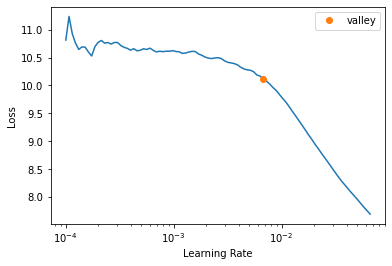

In [56]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=1e-01)

In [57]:
learn_bnb.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,time
0,5.022657,4.714149,00:01
1,4.704928,4.704531,00:01
2,4.643118,4.693146,00:01
3,4.583005,4.711914,00:01


In [58]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
3170,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,15,6,227,False,False,False,False,False,False,1.628986e+09


In [59]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [60]:
_, params = learn_bnb.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [61]:
params

tensor([-1.9461, -2.3060,  3.5287,  5.5115, -0.5038])

In [62]:
alpha = F.softplus(params[0:2])
mu = F.softplus(params[2:4])
omega = torch.tanh(params[4]) * 0.0

total_count = 1. / alpha
logits = torch.log(alpha * mu)

print(alpha, mu, omega)

tensor([0.1335, 0.0950]) tensor([3.5576, 5.5156]) tensor(-0.)


In [63]:
bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)

In [64]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([3.5576, 5.5156]) tensor([5.2473, 8.4055])


In [65]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([3.5576, 5.5156]) tensor([5.2473, 8.4055])


In [66]:
d = 1.-math.exp(-1)
corr = omega * d**2 * torch.sqrt(mu.prod()*(1.+alpha*mu).prod()) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod()
corr 

tensor(-0.)

In [67]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [68]:
corner = bnb_corner.log_prob(value).exp()

In [69]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [70]:
prob_lo, prob_hi

(tensor(0.6785), tensor(0.3215))

In [71]:
1/prob_lo, 1/prob_hi

(tensor(1.4737), tensor(3.1108))

### Train full model

In [72]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [73]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC
0,I2,Cittadella,Chievo,5,1.4,13.6,4.0,7.2,1.0,11.6,3.6,4.0,1.6,16.4,6.0,8.2,1.0,10.2,3.8,5.2,1.2,12.200000,4.6,5.2,1.4,11.6,5.0,3.8,2019.0,12.0,51.000000,21.0,354.999994,8.0,2.0
1,SP2,Logrones,Girona,6,0.4,7.2,1.8,3.6,1.4,9.2,3.4,3.2,0.4,11.0,2.6,4.4,1.8,9.8,3.2,4.8,0.2,9.800000,3.0,4.4,0.6,9.6,2.6,5.4,2021.0,5.0,18.000000,9.0,128.999998,3.0,4.0
2,D2,Karlsruhe,Werder Bremen,5,1.6,13.8,4.8,5.4,1.0,12.0,4.4,3.2,2.2,11.4,4.2,4.4,1.4,15.0,6.0,5.4,0.8,8.600000,3.0,5.4,2.6,14.4,6.4,4.0,2021.0,8.0,33.000000,21.0,232.999999,5.0,8.0
3,I2,Monza,Salernitana,2,2.2,18.4,7.0,6.2,0.8,10.8,2.8,4.2,2.6,15.8,6.8,4.8,1.2,8.4,2.4,3.4,0.6,9.600000,2.6,5.0,1.2,19.0,4.8,7.0,2020.0,12.0,53.000000,30.0,365.000002,3.0,3.0
4,SP2,Rayo Majadahonda,Alcorcon,6,0.6,9.2,2.8,4.4,0.4,11.4,3.0,4.4,1.0,10.6,4.0,3.4,1.0,11.4,3.0,3.6,1.4,14.600000,4.4,4.2,1.4,12.0,4.4,4.6,2019.0,3.0,10.000000,10.0,68.999994,1.0,5.0
5,SP2,Extremadura UD,Zaragoza,5,1.2,12.0,5.6,4.6,1.2,10.4,3.2,4.4,1.4,9.2,4.0,3.4,1.8,15.0,5.8,6.2,0.4,16.799999,4.4,8.4,1.2,10.8,4.0,3.8,2019.0,5.0,19.000000,11.0,131.000001,1.0,2.0
6,F2,Metz,Red Star,1,1.2,12.6,3.6,5.2,0.6,6.0,1.6,3.8,0.8,8.4,2.4,3.6,0.2,9.8,2.0,3.4,0.6,9.400000,3.0,5.6,2.4,15.6,4.4,4.8,2018.0,12.0,49.000000,4.0,337.999998,2.0,2.0
7,SP1,Celta,Levante,5,1.0,13.2,3.6,5.0,1.0,9.6,2.8,5.6,1.2,11.2,3.6,4.2,0.4,8.6,2.0,5.6,2.2,13.600000,6.2,6.6,1.6,16.0,4.6,4.0,2019.0,2.0,7.000001,16.0,46.999994,5.0,7.0
8,D1,Hertha,Hoffenheim,5,1.8,10.0,3.8,3.6,1.0,10.8,3.8,3.8,2.2,11.8,4.6,4.4,1.0,13.4,4.4,5.2,1.0,12.600000,4.8,6.2,1.6,14.0,4.4,6.0,2019.0,10.0,43.000000,26.0,299.000002,4.0,4.0
9,SP1,Leganes,Sevilla,6,1.2,12.2,4.8,5.2,1.4,11.8,3.8,5.2,1.2,11.8,3.8,4.6,1.4,16.4,6.0,5.6,0.6,10.600000,2.4,4.2,0.6,12.6,4.6,4.0,2018.0,12.0,51.000000,23.0,357.000004,3.0,6.0


In [74]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [75]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=114, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [76]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.00478630093857646)

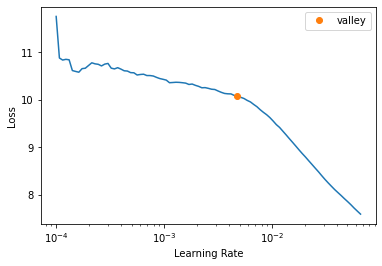

In [77]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=1e-01)

In [78]:
learn_bnb.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,time
0,4.926856,None,00:01
1,4.714597,None,00:01
2,4.644523,None,00:01
3,4.600404,None,00:01


/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [79]:
learn_bnb.export('models/learn_bnbsl.pkl')

In [80]:
to.export('models/to.pkl')

### t-SNE

In [81]:
df['HomeTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [82]:
df['AwayTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [83]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 267
['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves', 'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre', 'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento', 'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux', 'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly', 'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo', 'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry', 'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt', 'Derby', 'Dijon', 'Doncaster', 'Dortmund', 'Dresden', 'Duisburg', 'Dunkerque', 'Eibar', 'Ein Frankfurt

In [84]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' 

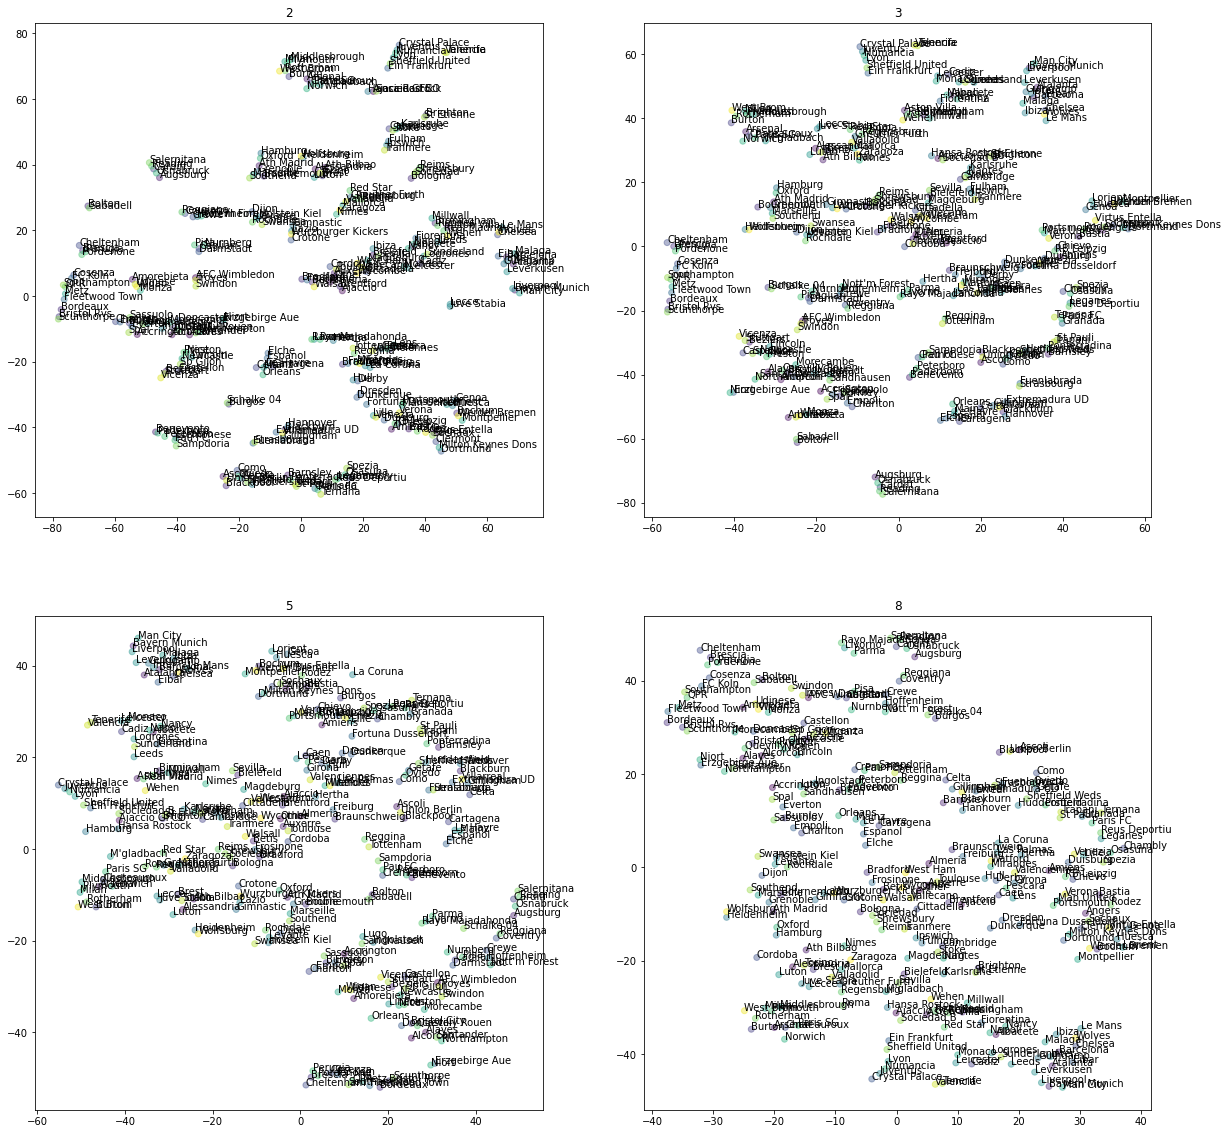

In [85]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END